In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggrepel)
    library(ggpp)
    library(dplyr)
    library(tidyr)
    library(RColorBrewer)
    library(readr) # for parse_number()
    library(clusterProfiler)
    library(patchwork)
    library(jsonlite)
})

In [2]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}   

In [3]:
merged_res_df = read.csv('copulacci_with_other_results.csv')

In [6]:
brca_df = merged_res_df %>%
    mutate(celltype_direction = interaction) %>%
    separate(interaction, into=c("source", "target"), sep = "=") 

In [4]:
lr_info_df = read.csv('seqfish_sdm_geneInter.csv')

In [7]:
brca_df = merge(
    brca_df,
    lr_info_df %>% select(c(X, interaction_name_2)) ,
    by.x = "LR_index",
    by.y = "X"
)

In [9]:
brca_df %>% pull(celltype_direction) %>% unique

[1] "L5 eNeuron=L6 eNeuron"   "L2/3 eNeuron=L4 eNeuron"
[3] "L6 eNeuron=L5 eNeuron"   "L4 eNeuron=L2/3 eNeuron"
[5] "L6 eNeuron=astrocytes"   "astrocytes=L6 eNeuron"

In [33]:
dotplot = function(
    brca_df, 
    celltype_name, 
    filter_pos=FALSE, 
    FDR_cutoff = 0.1,
    n_term = 5,
    put_arrow = FALSE,
    vertical = FALSE
){
    brca_df = brca_df %>% filter((source == celltype_name) | 
                    (target == celltype_name))

    dacr_tbl = brca_df %>% 
            mutate(Correlation = copula_coeff) %>%
            group_by(celltype_direction) %>%
            mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
            ungroup() %>%
            mutate(log10_p.adjust = -log10(qval)) %>%
            mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
            mutate(Cluster = celltype_direction) 
    
    if (put_arrow){
        dacr_tbl = dacr_tbl %>%
            mutate(Cluster = gsub("="," → ", celltype_direction)) 
    }

    dacr_tbl = dacr_tbl %>% mutate(Correlation = copula_coeff) %>% filter(qval < FDR_cutoff) %>%
            group_by(Cluster) %>% arrange(abs(Correlation)) %>% slice_tail(n=n_term) %>% ungroup

    if (filter_pos){
        dacr_tbl = dacr_tbl %>% filter(copula_coeff > 0)
    }
        
    # dacr_tbl = brca_df %>%
    #     mutate(Correlation = copula_coeff) %>%
    #     mutate(qval = p.adjust(pval, method = "BH")) %>%
    #     mutate(log10_p.adjust = -log10(qval)) %>%
    #     mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
    #     mutate(Cluster = celltype_direction) %>%
    #     #mutate(Cluster = enc2utf8(gsub("="," → ", celltype_direction))) %>%
    #     mutate(Correlation = copula_coeff) %>% 
    #     group_by(Cluster) %>% arrange(Correlation) %>% slice_tail(n=n_term) %>% ungroup
    mat <- dacr_tbl %>% 
      # select(Correlation, celltype_direction, LR_index) %>%  
      select(Correlation, celltype_direction, interaction_name_2) %>%  
      tidyr::pivot_wider(names_from = celltype_direction, values_from = Correlation) %>% 
      data.frame() # make df as tibbles -> matrix annoying
    
    df_toplot = dacr_tbl 
    # df_toplot$lig_rec = factor(df_toplot$LR_index, levels=mat$LR_index)
    df_toplot$lig_rec = factor(df_toplot$interaction_name_2, levels=mat$interaction_name_2)
    theme_cancer = theme_bw() + theme(
        legend.position = "bottom", 
        axis.text = element_text(color="black"), 
        axis.text.x = element_text(size=14, angle = 90, vjust = 0.5, hjust=1),
        plot.margin = margin(0,0,0,0,'pt')
    )

    if(vertical){
         p_dot = ggplot(df_toplot, 
                       aes_string(
                           x="lig_rec", y="Cluster", 
                           fill="log10_p.adjust_cap", size="Correlation")) +
          geom_point(shape=21, color="black") +
          paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                            limits = c(-log10(FDR_cutoff), 3.1), 
                                            breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                            labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
          #scale_size(range=c(1,7)) +
          scale_size_continuous(range = c(2, 7)) +
          theme_cancer +
          theme(
              axis.text = element_text(color="black"),
              axis.text.x = element_text(size=17, angle = 90, vjust =0.5, hjust=1)
          ) + 
          labs(y="", x="",title="", size="Correlation", fill="FDR") +
          theme(axis.text.y = element_text(size=18),
                axis.text.x = element_text(size=18)) +
          guides(fill = guide_colourbar(barwidth = 18, barheight = 1.5)) +
          theme(legend.position="bottom", legend.box="vertical",legend.text = element_text(size=16),
               legend.title = element_text(size=11)) +
          ggtitle(celltype_name) +
          theme(plot.title = element_text(hjust = 0.5))
    }else{

        p_dot = ggplot(df_toplot, 
                       aes_string(
                           x="Cluster", y="lig_rec", 
                           fill="log10_p.adjust_cap", size="Correlation")) +
          geom_point(shape=21, color="black") +
          paletteer::scale_fill_paletteer_c("grDevices::Heat", direction = -1, 
                                            limits = c(-log10(FDR_cutoff), 3.1), 
                                            breaks = -log10(c(FDR_cutoff, 0.1, 0.05, 0.01, 0.001)), 
                                            labels = c(FDR_cutoff, "0.1", "0.05", "0.01", "0.001")) +
          scale_size(range=c(1,7)) +
          theme_cancer +
          theme(
              axis.text = element_text(color="black"),
              axis.text.x = element_text(size=17, angle = 90, vjust = 0.5, hjust=1)
          ) + 
          labs(y="", x="",title="", size="Correlation", fill="FDR") +
          theme(axis.text.y = element_text(size=15)) +
          theme(legend.position="right", legend.box="vertical",legend.text = element_text(size=15),
               legend.title = element_text(size=15)) +
          ggtitle(celltype_name) +
          theme(plot.title = element_text(hjust = 0.5))
    }

    return(p_dot)
}

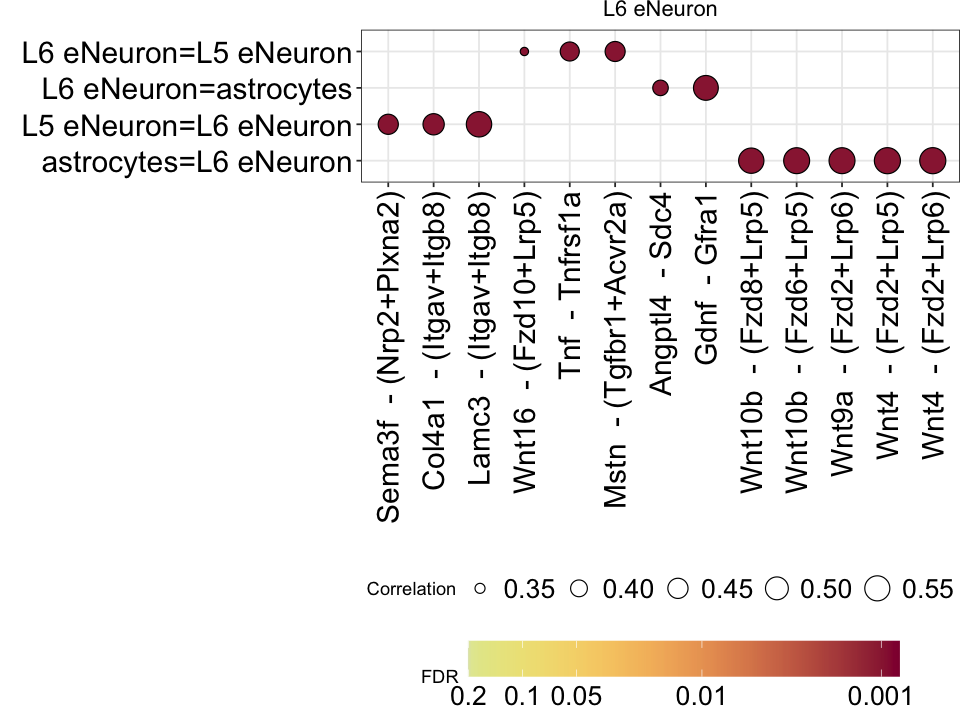

In [37]:
ct = 'L6 eNeuron'
fig.size(6,8)
dotplot(brca_df, ct,filter_pos=TRUE,FDR_cutoff=0.2,n_term=5,vertical = TRUE)

In [39]:
fig.size(6,8)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
file_name = "seqfish_cortex_dotplot_3_17.png"
file_path <- file.path(parent.dir , file_name)
p1 = dotplot(brca_df, 
        ct,filter_pos=TRUE, FDR_cutoff=0.2, n_term=5, vertical = TRUE,put_arrow = TRUE)
ggsave(file_path, p1, height=6, width=10, dpi = 500)

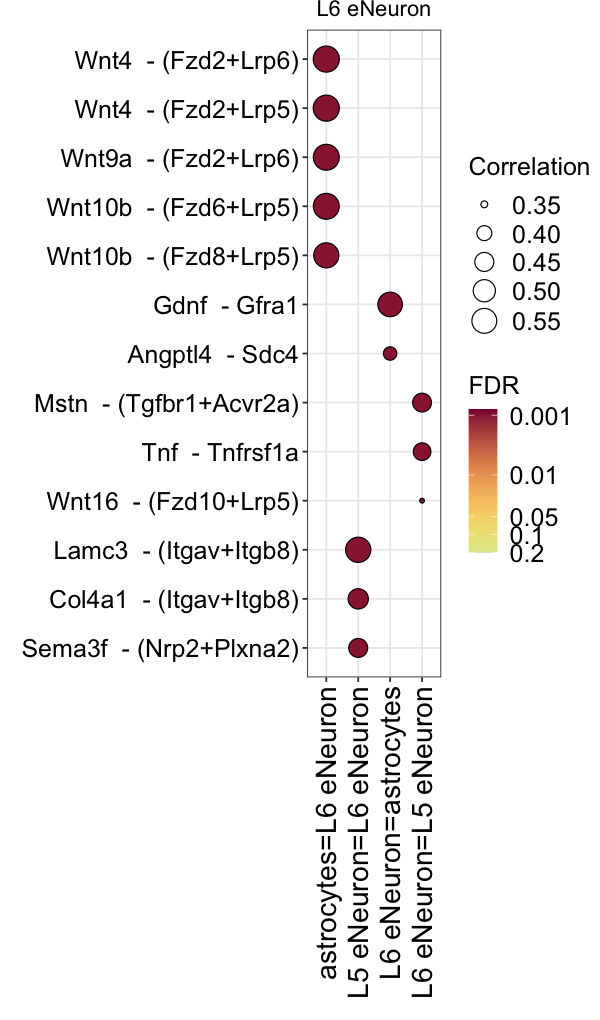

In [43]:
ct = 'L6 eNeuron'
fig.size(8.5,5)
dotplot(brca_df, ct,filter_pos=TRUE,FDR_cutoff=0.2,n_term=5)

In [45]:
fig.size(6,8)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
file_name = "seqfish_cortex_dotplot_vertical_3_17.png"
file_path <- file.path(parent.dir , file_name)
p1 = dotplot(brca_df, ct,filter_pos=TRUE,FDR_cutoff=0.2,n_term=5,put_arrow=TRUE)
# p1 = dotplot(brca_df, 
#         ct,filter_pos=TRUE, FDR_cutoff=0.2, n_term=5, vertical = TRUE,put_arrow = TRUE)
ggsave(file_path, p1, height=8, width=5, dpi = 500)

In [13]:
brca_df %>% pull(celltype_direction) %>% unique

[1] "L5 eNeuron=L6 eNeuron"   "L2/3 eNeuron=L4 eNeuron"
[3] "L6 eNeuron=L5 eNeuron"   "L4 eNeuron=L2/3 eNeuron"
[5] "L6 eNeuron=astrocytes"   "astrocytes=L6 eNeuron"

In [15]:
plot_scatter = function(
    brca_df,
    xcol = "copula_coeff",
    ycol = "scc",
    gpair = 'Tumor=Surrounding tumor',
    use_cutoff=TRUE,
    use_diff=TRUE,
    FDR_cutoff=0.1,
    ntop=5,
    p_value="qval",
    x_shift=0.2,
    y_shift=0.2,
    pad = 0.1
){

    df_ct = brca_df %>% 
        mutate(Correlation = copula_coeff) %>%
        group_by(celltype_direction) %>%
        mutate(qval = p.adjust(copula_pval, method = "BH")) %>%
        ungroup() %>%
        mutate(log10_p.adjust = -log10(qval)) %>%
        mutate(log10_p.adjust_cap = ifelse(log10_p.adjust>3, 3, log10_p.adjust)) %>%
        mutate(Cluster = celltype_direction) %>%
        filter(celltype_direction == gpair)
    
    df_ct = df_ct %>% 
        select(c(LR_index, copula_coeff, log10_p.adjust_cap, scc, 
                 global_I, qval, interaction_name_2))
    
    xmax = max(df_ct[[xcol]]) 
    xmin = min(df_ct[[xcol]])
    ymax = max(df_ct[[ycol]]) 
    ymin = min(df_ct[[ycol]])
    gmin = min(xmin, ymin)
    gmax = max(xmax, ymax)
    gmax = gmax + pad
    
    df_ct$method_diff = abs(df_ct[[xcol]] - df_ct[[ycol]])
    if(use_cutoff){
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
            
        }else{
            if (use_diff){
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(method_diff) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)
            }else{
                top_candidates = df_ct %>% filter(qval < FDR_cutoff) %>% 
                    arrange(abs(copula_coeff)) %>% 
                    slice_tail(n=ntop) %>% pull(LR_index)    
            }
        }
    
    
    
    p = ggplot(df_ct, aes_string(x = xcol, y = ycol, color = p_value)) +
          scale_color_gradient(
            # limits = c(-log10(max(df_ct$qval)), 3.1), 
            # breaks = -log10(c(0.9, 0.1, 0.05, 0.01, 0.001)), 
            # labels = c("0.9", "0.1", "0.05", "0.01", "0.001"),
            low = "blue", high = "grey") +
          geom_point(alpha = 0.6, size=3) + 
          geom_point(data = df_ct %>% filter(LR_index %in% top_candidates), 
                     color = "red", size = 3.5, stroke=1.3, shape = 1) +
        xlim(-gmax,gmax) +
        ylim(-gmax,gmax) +
        labs(color ='FDR') +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black") +  # Horizontal dashed line
          geom_vline(xintercept = 0, linetype = "dashed", color = "black") +  # Vertical dashed line
        geom_label_repel(
            data = df_ct %>% filter(LR_index %in% top_candidates),
            aes_string(x = xcol, y= ycol, label = "interaction_name_2"),
            position=position_nudge_center(x = x_shift,y= y_shift ,
                                           center_x = 0.0
                                           # center_y = 0.0
                                          ),
            #family = "Poppins",
            size = 5,
            min.segment.length = 0, 
            seed = 42, 
            box.padding = 0.1,
            max.overlaps = Inf,
            xlim = c(NA, NA),
            ylim = c(NA, NA),
            arrow = arrow(length = unit(0.01, "npc")),
            # nudge_x = .1,
            # #nudge_y = -.1,
            #fill="white",
            color = "red"
          ) +
          theme_bw() +
          theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            axis.line = element_line(colour = "black"),
            # axis.title.x = element_blank(),
            # axis.title.y = element_blank(),
            axis.text.x = element_text(family = "Helvetica", size = 18, color = "black"),
            axis.text.y = element_text(family = "Helvetica", size = 18, color = "black"),
            legend.text = element_text(size=16),
            legend.title = element_text(size=16)
          )
    return(p)
}

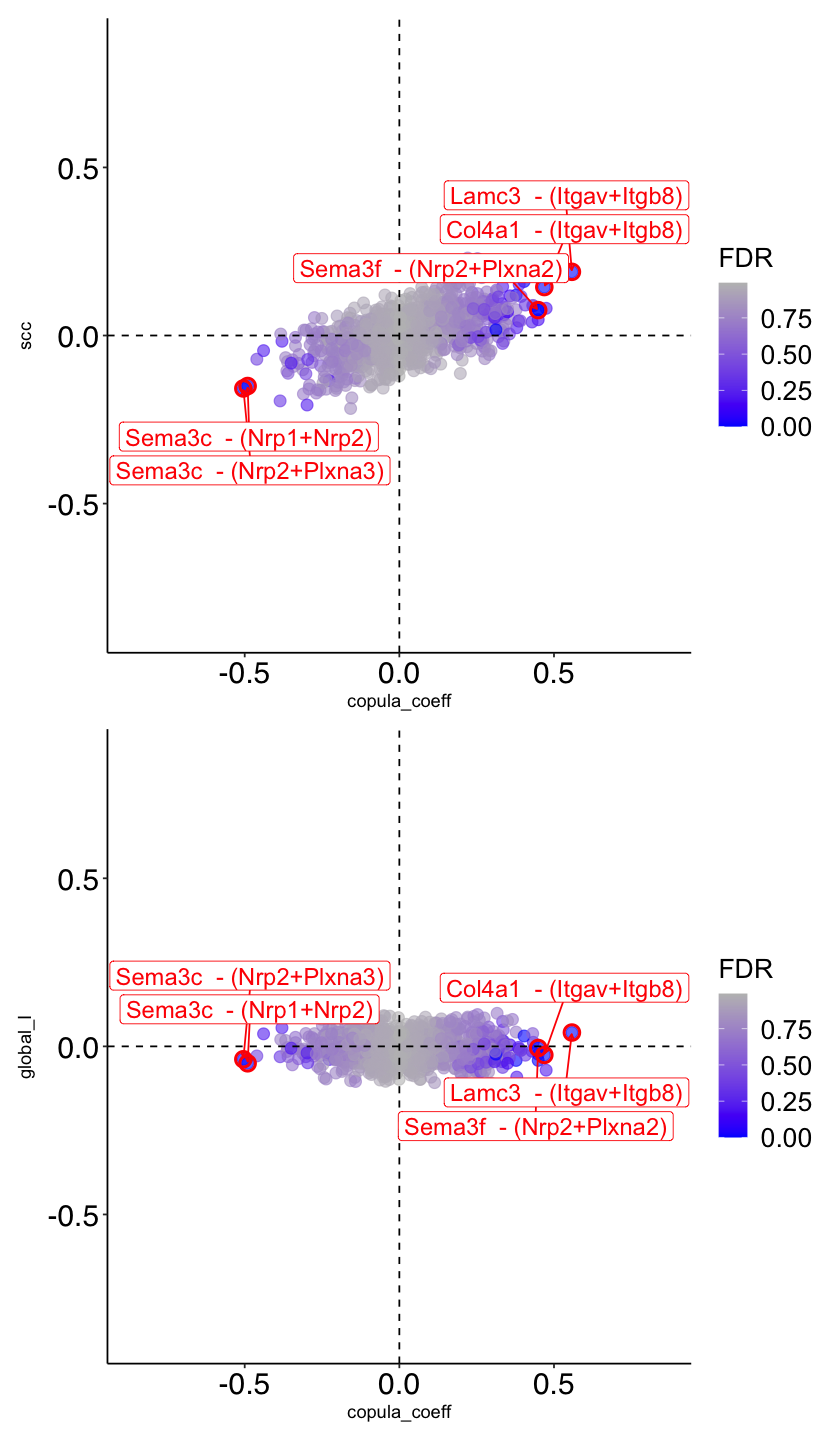

In [16]:
fig.size(12, 7)
gpair = 'L5 eNeuron=L6 eNeuron'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)
p3 = p1 / p2
p3

In [ ]:
fig.size(12, 7)
gpair = 'L5 eNeuron=L6 eNeuron'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)
p3 = p1 / p2
p3

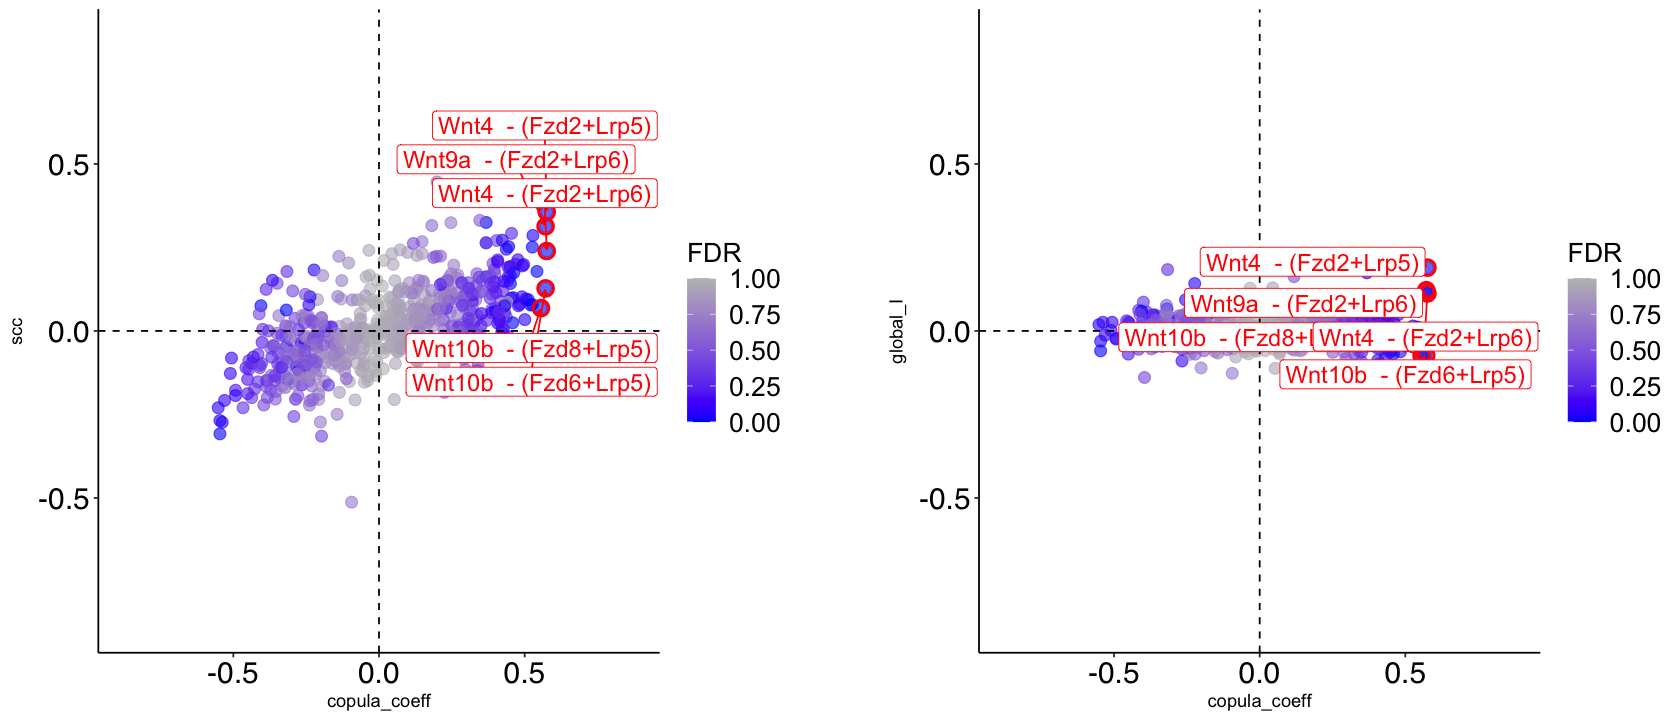

In [51]:
fig.size(6, 14)
gpair = 'astrocytes=L6 eNeuron'
p1 = plot_scatter(brca_df, "copula_coeff", "scc", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3)
p2 = plot_scatter(brca_df, "copula_coeff", "global_I", gpair,ntop=5,FDR_cutoff=0.1, 
                  use_diff = FALSE,
                  use_cutoff=TRUE, pad=0.3,x_shift=0.1, y_shift=-0.2)
p3 = p1 / p2
p3 = (p1 + theme(plot.margin = unit(c(0,30,0,0), "pt"))) +
(p2 + theme(plot.margin = unit(c(0,0,0,30), "pt")))
p3

In [50]:
fig.size(6,14)
parent.dir = '/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/ISMB_figures_version_2/'
file_name = "seqfish_scatter_3_17.png"
file_path <- file.path(parent.dir , file_name)
ggsave(file_path, p3, height=6, width=14, dpi = 500)